In [1]:
###########import packages##########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn.tree import ExtraTreeRegressor
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneOut
seed= 6866
###########import packages##########
import catboost
import xgboost
import lightgbm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import *
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import  *

In [2]:
###########wrapping root mean square error for later calls##########
def compute_mae_mse_rmse(target,prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)  # target-prediction之差平方
        absError.append(abs(val))  # 误差绝对值
    mae=sum(absError)/len(absError)  # 平均绝对误差MAE
    mse=sum(squaredError)/len(squaredError)  # 均方误差MSE
    RMSE=np.sqrt(sum(squaredError)/len(squaredError))
    R2=r2_score(target,prediction)
    return mae,mse,RMSE,R2
def gridsearch(model,param,algorithm_name,X_train,y_train,X_test,y_test):
    grid = GridSearchCV(model,param_grid=param,scoring='neg_mean_absolute_error',cv=10,n_jobs=-1,verbose=-1)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    ####Train####
    prediction_train = best_model.predict(X_train)
    real_train=y_train.values
    prediction_train_series=pd.Series(prediction_train)
    real_train_series=pd.Series(real_train)
    corr_ann_train = round(prediction_train_series.corr(real_train_series), 5)
    error_val_train= compute_mae_mse_rmse(prediction_train,real_train)
    ####test####
    prediction_test = best_model.predict(X_test)
    real_test=y_test.values
    prediction_test_series=pd.Series(prediction_test)
    real_test_series=pd.Series(real_test)
    corr_ann_test = round(prediction_test_series.corr(real_test_series), 5)
    error_val_test= compute_mae_mse_rmse(prediction_test,real_test)
    print(algorithm_name)
    best_score=grid.best_score_
    print('Best Regressor:',grid.best_params_,'Best Score:', best_score)
    print(error_val_test)
    print('R2 TEST',error_val_test[3])
    fig=plt.figure()
    ax = fig.add_subplot(111)
    x_y_x=np.arange(100,1500,0.01)
    x_y_y=np.arange(100,1500,0.01)
    ax.scatter(prediction_train,real_train,c='blue',label='Train',alpha=0.25)
    ax.scatter(prediction_test,real_test,c='red',label='Test',alpha=0.75)
    ax.plot(x_y_x,x_y_y,c='black')
    plt.legend()
    plt.xlabel('Predicted_Overpotential@10 mA cm-2')
    plt.ylabel('Real_Overpotential@10 mA cm-2')
    return best_model,error_val_test[3]

In [3]:
fl = open(r'./database_high_quality_ac_for_inter.pkl','rb')
database_full=pickle.load(fl)
data_input_full=database_full.iloc[:,0:54]
data_output_full=database_full.iloc[:,54]
X_train,X_test,y_train,y_test=train_test_split(data_input_full,data_output_full,test_size=0.1,random_state=seed)

CatBoost
Best Regressor: {'boosting_type': 'Plain', 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400, 'reg_lambda': 0.001, 'subsample': 0.9} Best Score: -41.169930713806025
(29.492658145129624, 1621.5435072451974, 40.26839340283142, 0.8018264659696333)
R2 TEST 0.8018264659696333


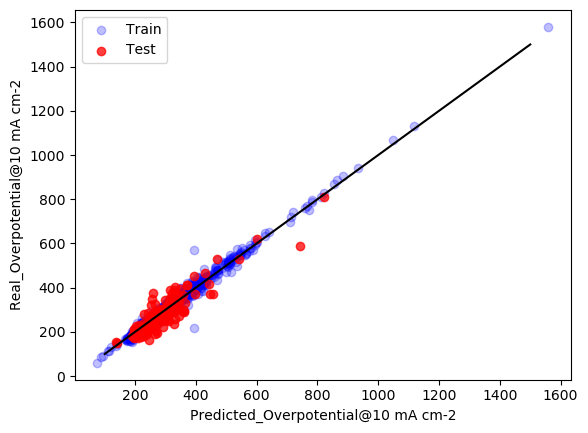

In [4]:
model_CatRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
param_cat = {
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2],
# 'n_estimators':[100,200,400],
# "boosting_type":["Plain"],
# 'max_depth':[5,7,9,11],
# 'subsample':[0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
    'boosting_type': ['Plain'], 'learning_rate': [0.1], 'max_depth': [7], 'n_estimators': [400], 'reg_lambda': [0.001], 'subsample': [0.9]
}
CAT_full,CAT_full_score=gridsearch(model_CatRegressor,param_cat,'CatBoost',X_train,y_train,X_test,y_test)

XGBoost
Best Regressor: {'booster': 'gbtree', 'learning_rate': 0.02, 'max_depth': 13, 'n_estimators': 400, 'reg_alpha': 0, 'reg_lambda': 1e-05, 'subsample': 0.7} Best Score: -42.9925951839113
(27.210974412805893, 1514.7075223920178, 38.91924359994703, 0.82177610806912)
R2 TEST 0.82177610806912


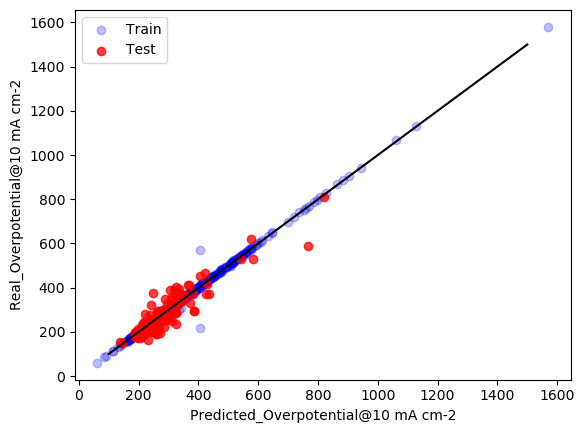

In [5]:
model_XGRegressor=XGBRegressor(random_state=1)
param_xg={
# 'booster':['gbtree'],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'n_estimators':[100,200,400],
# 'max_depth':[3,5,7,9,11,13,-1],
# 'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
    'booster': ['gbtree'], 'learning_rate': [0.02], 'max_depth': [13], 'n_estimators': [400], 'reg_alpha': [0], 'reg_lambda': [1e-05], 'subsample': [0.7]
}
XG_full,XG_full_score=gridsearch(model_XGRegressor,param_xg,'XGBoost',X_train,y_train,X_test,y_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

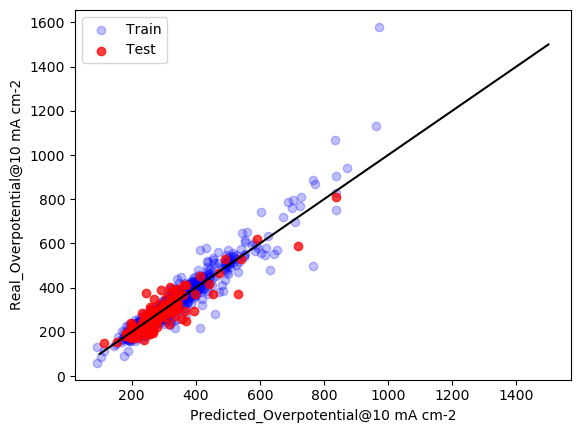

In [6]:
model_LGBMRegressor=LGBMRegressor(random_state=1,verbose=0)
param_lgbm = {
# 'boosting_type':['gbdt','rf'],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'n_estimators':[50,100,200,400],
# 'max_depth':[5,7,9,11,13,-1],
# 'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
    'boosting_type': ['gbdt'], 'learning_rate': [0.16], 'max_depth': [13], 'n_estimators': [100], 'reg_alpha': [0.001], 'reg_lambda': [0], 'subsample': [0.7]
}
LGBM_full,LGBM_full_score=gridsearch(model_LGBMRegressor,param_lgbm,'LightGBM',X_train,y_train,X_test,y_test)

In [7]:
import math
from pdpbox.pdp_calc_utils import _calc_ice_lines_inter
from pdpbox.pdp import pdp_isolate, PDPInteract
from pdpbox.utils import (_check_model, _check_dataset, _check_percentile_range, _check_feature,
                    _check_grid_type, _check_memory_limit, _make_list,
                    _calc_memory_usage, _get_grids, _get_grid_combos, _check_classes)
from joblib import Parallel, delayed

def pdp_multi_interact(model, dataset, model_features, features, 
                    num_grid_points=None, grid_types=None, percentile_ranges=None, grid_ranges=None, cust_grid_points=None, 
                    cust_grid_combos=None, use_custom_grid_combos=False,
                    memory_limit=0.9, n_jobs=8, predict_kwds=None, data_transformer=None):

    def _expand_default(x, default, length):
        if x is None:
            return [default] * length
        return x

    def _get_grid_combos(feature_grids, feature_types):
        grids = [np.array(list(feature_grid),dtype=np.float16) for feature_grid in feature_grids]
        for i in range(len(feature_types)):
            if feature_types[i] == 'onehot':
                grids[i] = np.eye(len(grids[i])).astype(int).tolist()
        return np.stack(np.meshgrid(*grids,copy=bool), -1).reshape(-1, len(grids))

    if predict_kwds is None:
        predict_kwds = dict()

    nr_feats = len(features)

    # check function inputs
    n_classes, predict = _check_model(model=model)
    _check_dataset(df=dataset)
    _dataset = dataset.copy()

    # prepare the grid
    pdp_isolate_outs = []
    if use_custom_grid_combos:
        grid_combos = cust_grid_combos
        feature_grids = []
        feature_types = []
    else:
        num_grid_points = _expand_default(x=num_grid_points, default=10, length=nr_feats)
        grid_types = _expand_default(x=grid_types, default='percentile', length=nr_feats)
        for i in range(nr_feats):
            _check_grid_type(grid_type=grid_types[i])

        percentile_ranges = _expand_default(x=percentile_ranges, default=None, length=nr_feats)
        for i in range(nr_feats):
            _check_percentile_range(percentile_range=percentile_ranges[i])

        grid_ranges = _expand_default(x=grid_ranges, default=None, length=nr_feats)
        cust_grid_points = _expand_default(x=cust_grid_points, default=None, length=nr_feats)

        _check_memory_limit(memory_limit=memory_limit)

        pdp_isolate_outs = []
        for idx in range(nr_feats):
            pdp_isolate_out = pdp_isolate(
                model=model, dataset=_dataset, model_features=model_features, feature=features[idx],
                num_grid_points=num_grid_points[idx], grid_type=grid_types[idx], percentile_range=percentile_ranges[idx],
                grid_range=grid_ranges[idx], cust_grid_points=cust_grid_points[idx], memory_limit=memory_limit,
                n_jobs=n_jobs, predict_kwds=predict_kwds, data_transformer=data_transformer)
            pdp_isolate_outs.append(pdp_isolate_out)

        if n_classes > 2:
            feature_grids = [pdp_isolate_outs[i][0].feature_grids for i in range(nr_feats)]
            feature_types = [pdp_isolate_outs[i][0].feature_type  for i in range(nr_feats)]
        else:
            feature_grids = [pdp_isolate_outs[i].feature_grids for i in range(nr_feats)]
            feature_types = [pdp_isolate_outs[i].feature_type  for i in range(nr_feats)]

        grid_combos = _get_grid_combos(feature_grids, feature_types)

    feature_list = []
    for i in range(nr_feats):
        feature_list.extend(_make_list(features[i]))

    # Parallel calculate ICE lines
    true_n_jobs = _calc_memory_usage(
        df=_dataset, total_units=len(grid_combos), n_jobs=n_jobs, memory_limit=memory_limit)

    grid_results = Parallel(n_jobs=true_n_jobs)(delayed(_calc_ice_lines_inter)(
        grid_combo, data=_dataset, model=model, model_features=model_features, n_classes=n_classes,
        feature_list=feature_list, predict_kwds=predict_kwds, data_transformer=data_transformer)
                                                for grid_combo in grid_combos)

    ice_lines = pd.concat(grid_results, axis=0).reset_index(drop=True)
    pdp = ice_lines.groupby(feature_list, as_index=False).mean()

    # combine the final results
    pdp_interact_params = {'n_classes': n_classes, 
                        'features': features, 
                        'feature_types': feature_types,
                        'feature_grids': feature_grids}
    if n_classes > 2:
        pdp_interact_out = []
        for n_class in range(n_classes):
            _pdp = pdp[feature_list + ['class_%d_preds' % n_class]].rename(
                columns={'class_%d_preds' % n_class: 'preds'})
            pdp_interact_out.append(
                PDPInteract(which_class=n_class,
                            pdp_isolate_outs=[pdp_isolate_outs[i][n_class] for i in range(nr_feats)],
                            pdp=_pdp, **pdp_interact_params))
    else:
        pdp_interact_out = PDPInteract(
            which_class=None, pdp_isolate_outs=pdp_isolate_outs, pdp=pdp, **pdp_interact_params)

    return pdp_interact_out
print('ready')

ready


In [8]:
def center(arr): return arr - np.mean(arr)
import itertools
def compute_f_vals(mdl, X, features, selectedfeatures, num_grid_points=10, use_data_grid=False):
    f_vals = {}
    data_grid = None
    if use_data_grid:
        data_grid = X[selectedfeatures].values
    # Calculate partial dependencies for full feature set
    p_full = pdp_multi_interact(mdl, X, features, selectedfeatures, 
                                num_grid_points=[num_grid_points] * len(selectedfeatures),
                                cust_grid_combos=data_grid,
                                use_custom_grid_combos=use_data_grid)
    f_vals[tuple(selectedfeatures)] = center(p_full.pdp.preds.values)
    grid = p_full.pdp.drop('preds', axis=1)
    # Calculate partial dependencies for [1..SFL-1]
    for n in range(1, len(selectedfeatures)):
        for subsetfeatures in itertools.combinations(selectedfeatures, n):
            if use_data_grid:
                data_grid = X[list(subsetfeatures)].values
            p_partial = pdp_multi_interact(mdl, X, features, subsetfeatures, 
                                        num_grid_points=[num_grid_points] * len(selectedfeatures),
                                        cust_grid_combos=data_grid,
                                        use_custom_grid_combos=use_data_grid)
            p_joined = pd.merge(grid, p_partial.pdp, how='left')
            f_vals[tuple(subsetfeatures)] = center(p_joined.preds.values)
    return f_vals
def compute_h_val(f_vals, selectedfeatures):
    denom_els = f_vals[tuple(selectedfeatures)].copy()
    numer_els = f_vals[tuple(selectedfeatures)].copy()
    sign = -1.0
    for n in range(len(selectedfeatures)-1, 0, -1):
        for subfeatures in itertools.combinations(selectedfeatures, n):
            print(tuple(subfeatures))
            numer_els += sign * f_vals[tuple(subfeatures)]
        sign *= -1.0
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return math.sqrt(numer/denom) if numer < denom else np.nan
def compute_h_val_any(f_vals, allfeatures, selectedfeature):
    otherfeatures = list(allfeatures)
    otherfeatures.remove(selectedfeature)
    denom_els = f_vals[tuple(allfeatures)].copy()
    numer_els = denom_els.copy()
    numer_els -= f_vals[(selectedfeature,)]
    numer_els -= f_vals[tuple(otherfeatures)]
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return math.sqrt(numer/denom) if numer < denom else np.nan
def compute_interactions(model,X_train,feature_all,feature_select_list):  
    result_dict={}
    for i in range(len(feature_select_list)):
        for j in range(len(feature_select_list)):
            if i<j :
                print(i,j)
                try:
                    current_features=[feature_select_list[i],feature_select_list[j]]
                    f_vals=compute_f_vals(model, X_train, feature_all,current_features) 
                    result_dict[tuple(current_features)]=compute_h_val(f_vals,current_features)
                except:
                    result_dict[tuple(current_features)]=0
                print(result_dict[tuple(current_features)])
    return result_dict

In [9]:
CAT_DICT=compute_interactions(CAT_full,data_input_full,data_input_full.columns,list(data_input_full.columns))

0 1
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Number',)
0.10515414245175413
0 2
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Period',)
5.686445625332787e-15
0 3
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Group',)
0.1603599491477443
0 4
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Ionization Potential',)
0.1540637606821557
0 5
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Electronegativity',)
0.26763288865124046
0 6
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Number of d electrons',)
0.004980566963981488
0 7
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Radius',)
0.02375590737736056
0 8
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.04808226257338978
0 9
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Atomic Number',)
0.10485571320395455
0 10
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Period',)
0.11293047753581176
0 11

('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Atomic Radius',)
1.1058250139650634e-14
1 32
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.15502071852565064
1 33
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.09737819056163449
1 34
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.2127515736240202
1 35
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.042734309297120354
1 36
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Temperature (Celcius degree)',)
0.08663016527891897
1 37
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Time (min)',)
0.3784968353065694
1 38
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Still/Strring (0/1)',)
0.03649914123324098
1 39
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
1.745905784564357e-14
1 40
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.0

('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Group',)
0.47574040527436917
3 20
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Ionization Potential',)
0.16218101149176814
3 21
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Electronegativity',)
0.0061236196243850925
3 22
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Number of d electrons',)
0.041376053572829266
3 23
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Atomic Radius',)
0.10160733601092936
3 24
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Relative Atomic Mass',)
0.016300662614068102
3 25
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Atomic Number',)
6.1702668247163625e-15
3 26
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Period',)
0.01166299618937345
3 27
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Group',)
1.6636075306233985e-14
3 28
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Ionization Potential',)
1.6632843703410353e-14
3 29
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Electronegativity',)
1.1558890051791062e-14
3 30
('Metal_Dopant_1 Group',)
('Metal_D

('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Number of d electrons',)
0.07148803778364465
5 7
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Atomic Radius',)
0.21889228093594626
5 8
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.02626599091763858
5 9
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Atomic Number',)
0.15378288654443428
5 10
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Period',)
0.03377337622537293
5 11
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Group',)
0.028680252815047748
5 12
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Ionization Potential',)
0.080864502836424
5 13
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Electronegativity',)
0.039412300277816545
5 14
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Number of d electrons',)
0.26898983753194217
5 15
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Atomic Radius',)
0.07676125980132614
5 16
('Metal_Dopant

('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
1.2934744025177334e-14
6 41
('Metal_Dopant_1 Number of d electrons',)
('Mixed in Solid or Liquid (0/1)',)
0.07037354562394656
6 42
('Metal_Dopant_1 Number of d electrons',)
('Annealing Temperature (Celcius Degree)',)
0.10835872245745412
6 43
('Metal_Dopant_1 Number of d electrons',)
('Annealing Time (min)',)
0.06408062230242988
6 44
('Metal_Dopant_1 Number of d electrons',)
('Annealing Still/Strring (0/1)',)
0.001134037031553918
6 45
('Metal_Dopant_1 Number of d electrons',)
('Annealing Atomosphere Inert (0/1)',)
0.029752352073321116
6 46
('Metal_Dopant_1 Number of d electrons',)
('Annealing Atomosphere Reductive (0/1)',)
1.3465241102414478e-14
6 47
('Metal_Dopant_1 Number of d electrons',)
('Post-processing Acid Wash etc. (0/1)',)
2.910257676632181e-15
6 48
('Metal_Dopant_1 Number of d electrons',)
('Catalyst Loading (mg cm -2)',)
0.08426448577497346
6 49
('Metal_Dopant_1 Number of d electrons',

('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Radius',)
0.5580991390697678
8 32
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.14323919074010102
8 33
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.21348793572833996
8 34
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.3071882122523447
8 35
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Proportion in Precursor ',)
2.243769975231606e-14
8 36
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Temperature (Celcius degree)',)
0.08542034092172703
8 37
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Time (min)',)
0.0804443739228779
8 38
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Still/Strring (0/1)',)
0.016367073650663703
8 39
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
2.910798464151912e-14
8 40
('Metal_Dopant_2 Relative

('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Group',)
9.528158413588256e-14
10 28
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Ionization Potential',)
9.478232633519367e-14
10 29
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Electronegativity',)
0.0
10 30
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Number of d electrons',)
0.6476942910224469
10 31
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Atomic Radius',)
4.001144932020561e-14
10 32
('Metal_Dopant_2 Period',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.06905637274965655
10 33
('Metal_Dopant_2 Period',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.03886382499213166
10 34
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.05048867632023327
10 35
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Proportion in Precursor ',)
1.3002713327119143e-13
10 36
('Metal_Dopant_2 Period',)
('Hydrothermal Temperature (Celcius degree)',)
0.029141490308528247
10 37
('Metal_Dopant_2 Period',)
('Hydrothermal Time (min)',)
0.21413270475

('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Atomic Radius',)
1.0831145913093818e-14
12 32
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.16795065499643674
12 33
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.055036753858592254
12 34
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.0025035094089431785
12 35
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Proportion in Precursor ',)
2.201994704712064e-14
12 36
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Temperature (Celcius degree)',)
0.02609039381619024
12 37
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Time (min)',)
0.08020393059831371
12 38
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Still/Strring (0/1)',)
0.015811443068618834
12 39
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
1.6641968152710873e-14
12 40
('Meta

('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Atomic Radius',)
4.311526791629745e-15
14 32
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.19749767101994606
14 33
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.05494812179307467
14 34
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.019759539982711023
14 35
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Proportion in Precursor ',)
6.968984501787161e-15
14 36
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Temperature (Celcius degree)',)
0.06668343722600198
14 37
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Time (min)',)
0.08878804902345509
14 38
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Still/Strring (0/1)',)
0.1996619374136379
14 39
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
1.0711469899077072e-14
14 40
('

('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Temperature (Celcius degree)',)
0.28585336314577287
16 37
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Time (min)',)
0.28270754996662917
16 38
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Still/Strring (0/1)',)
5.2919868480092355e-14
16 39
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
5.301400881127449e-14
16 40
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.22191755311106978
16 41
('Metal_Dopant_3 Relative Atomic Mass',)
('Mixed in Solid or Liquid (0/1)',)
8.070622739352208e-14
16 42
('Metal_Dopant_3 Relative Atomic Mass',)
('Annealing Temperature (Celcius Degree)',)
0.08476436993281865
16 43
('Metal_Dopant_3 Relative Atomic Mass',)
('Annealing Time (min)',)
0.04011122323823537
16 44
('Metal_Dopant_3 Relative Atomic Mass',)
('Annealing Still/Strring (0/1)',)
0.021201732366915017
16 45
('Metal_Dopant_3 Relative Atomic M

('Metal_Dopant_3 Period',)
('Support Material Loading (mg cm -2)',)
0.24079934897181635
18 50
('Metal_Dopant_3 Period',)
('Support is not Carbon (0/1)',)
2.901112169795658e-14
18 51
('Metal_Dopant_3 Period',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.5871656267057648
18 52
('Metal_Dopant_3 Period',)
('LSV Scanning Speed (mV s-1)',)
1.1511063396774503e-14
18 53
('Metal_Dopant_3 Period',)
('Electrolyte Proton Concentration (M)',)
1.4028745081580702e-14
19 20
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Ionization Potential',)
0.3139838042345957
19 21
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Electronegativity',)
0.09272543971805602
19 22
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Number of d electrons',)
8.63036484990807e-14
19 23
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Atomic Radius',)
0.07411147871673252
19 24
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Relative Atomic Mass',)
6.168021000623363e-14
19 25
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Atomic Number'

('Metal_Dopant_3 Electronegativity',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.020670982854941473
21 34
('Metal_Dopant_3 Electronegativity',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.30324718922932564
21 35
('Metal_Dopant_3 Electronegativity',)
('Metal_Dopant_4 Proportion in Precursor ',)
3.5472566427630583e-14
21 36
('Metal_Dopant_3 Electronegativity',)
('Hydrothermal Temperature (Celcius degree)',)
0.037876230424330776
21 37
('Metal_Dopant_3 Electronegativity',)
('Hydrothermal Time (min)',)
0.050042378660350106
21 38
('Metal_Dopant_3 Electronegativity',)
('Hydrothermal Still/Strring (0/1)',)
6.021423398873477e-14
21 39
('Metal_Dopant_3 Electronegativity',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
2.1108508154244504e-14
21 40
('Metal_Dopant_3 Electronegativity',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
9.164358335526887e-14
21 41
('Metal_Dopant_3 Electronegativity',)
('Mixed in Solid or Liquid (0/1)',)
0.9361079556799229
21 42
('Metal_Dopant_3 Electroneg

('Metal_Dopant_3 Atomic Radius',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.11577627503527994
23 52
('Metal_Dopant_3 Atomic Radius',)
('LSV Scanning Speed (mV s-1)',)
0.04214134403356678
23 53
('Metal_Dopant_3 Atomic Radius',)
('Electrolyte Proton Concentration (M)',)
0.047669705001982116
24 25
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Number',)
1.9382009521597246e-13
24 26
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Period',)
2.124893696908559e-12
24 27
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Group',)
1.4809641613936334e-11
24 28
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Ionization Potential',)
5.062061322546554e-13
24 29
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Electronegativity',)
0.0
24 30
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Number of d electrons',)
5.661113179086205e-14
24 31
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Radius',)

('Metal_Dopant_4 Period',)
('Support is not Carbon (0/1)',)
5.640450984086387e-14
26 51
('Metal_Dopant_4 Period',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
3.855681424947609e-14
26 52
('Metal_Dopant_4 Period',)
('LSV Scanning Speed (mV s-1)',)
3.259252310866794e-15
26 53
('Metal_Dopant_4 Period',)
('Electrolyte Proton Concentration (M)',)
1.0038408545357132e-14
27 28
('Metal_Dopant_4 Group',)
('Metal_Dopant_4 Ionization Potential',)
5.063750425850515e-13
27 29
('Metal_Dopant_4 Group',)
('Metal_Dopant_4 Electronegativity',)
0.0
27 30
('Metal_Dopant_4 Group',)
('Metal_Dopant_4 Number of d electrons',)
5.6611308893687345e-14
27 31
('Metal_Dopant_4 Group',)
('Metal_Dopant_4 Atomic Radius',)
0.0
27 32
('Metal_Dopant_4 Group',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.00682113510969556
27 33
('Metal_Dopant_4 Group',)
('Metal_Dopant_2 Proportion in Precursor ',)
2.4989323898422188e-14
27 34
('Metal_Dopant_4 Group',)
('Metal_Dopant_3 Proportion in Precursor ',)
3.0

('Metal_Dopant_4 Number of d electrons',)
('Metal_Dopant_4 Proportion in Precursor ',)
3.835464932492195e-14
30 36
('Metal_Dopant_4 Number of d electrons',)
('Hydrothermal Temperature (Celcius degree)',)
1.3199618094712946e-14
30 37
('Metal_Dopant_4 Number of d electrons',)
('Hydrothermal Time (min)',)
0.2802814402777167
30 38
('Metal_Dopant_4 Number of d electrons',)
('Hydrothermal Still/Strring (0/1)',)
4.8463602416610215e-14
30 39
('Metal_Dopant_4 Number of d electrons',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0
30 40
('Metal_Dopant_4 Number of d electrons',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
2.7914296055025283e-14
30 41
('Metal_Dopant_4 Number of d electrons',)
('Mixed in Solid or Liquid (0/1)',)
7.043461011398793e-14
30 42
('Metal_Dopant_4 Number of d electrons',)
('Annealing Temperature (Celcius Degree)',)
2.150318107978385e-15
30 43
('Metal_Dopant_4 Number of d electrons',)
('Annealing Time (min)',)
3.7590626900830484e-15
30 44
('Metal_Dopant_4 Numbe

('Metal_Dopant_2 Proportion in Precursor ',)
('Support is not Carbon (0/1)',)
0.018501246301907744
33 51
('Metal_Dopant_2 Proportion in Precursor ',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.15451326740923757
33 52
('Metal_Dopant_2 Proportion in Precursor ',)
('LSV Scanning Speed (mV s-1)',)
0.29190084520385257
33 53
('Metal_Dopant_2 Proportion in Precursor ',)
('Electrolyte Proton Concentration (M)',)
0.14667279843739092
34 35
('Metal_Dopant_3 Proportion in Precursor ',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.027486618748227522
34 36
('Metal_Dopant_3 Proportion in Precursor ',)
('Hydrothermal Temperature (Celcius degree)',)
0.1803185834827346
34 37
('Metal_Dopant_3 Proportion in Precursor ',)
('Hydrothermal Time (min)',)
0.35368147331616945
34 38
('Metal_Dopant_3 Proportion in Precursor ',)
('Hydrothermal Still/Strring (0/1)',)
0.03139147591484238
34 39
('Metal_Dopant_3 Proportion in Precursor ',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
1.56

('Hydrothermal Still/Strring (0/1)',)
('Mixed in Solid or Liquid (0/1)',)
7.214473034913328e-14
38 42
('Hydrothermal Still/Strring (0/1)',)
('Annealing Temperature (Celcius Degree)',)
0.10496050456726148
38 43
('Hydrothermal Still/Strring (0/1)',)
('Annealing Time (min)',)
0.035083294385675035
38 44
('Hydrothermal Still/Strring (0/1)',)
('Annealing Still/Strring (0/1)',)
0.09575528639648907
38 45
('Hydrothermal Still/Strring (0/1)',)
('Annealing Atomosphere Inert (0/1)',)
0.05964252652317793
38 46
('Hydrothermal Still/Strring (0/1)',)
('Annealing Atomosphere Reductive (0/1)',)
0.1777008198022711
38 47
('Hydrothermal Still/Strring (0/1)',)
('Post-processing Acid Wash etc. (0/1)',)
1.2125303876272086e-14
38 48
('Hydrothermal Still/Strring (0/1)',)
('Catalyst Loading (mg cm -2)',)
0.07800349476256967
38 49
('Hydrothermal Still/Strring (0/1)',)
('Support Material Loading (mg cm -2)',)
0.03921836254555611
38 50
('Hydrothermal Still/Strring (0/1)',)
('Support is not Carbon (0/1)',)
0.0
38 51

('Annealing Still/Strring (0/1)',)
('Support Material Loading (mg cm -2)',)
0.0663846108137338
44 50
('Annealing Still/Strring (0/1)',)
('Support is not Carbon (0/1)',)
0.013990060290052538
44 51
('Annealing Still/Strring (0/1)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.043872481510782456
44 52
('Annealing Still/Strring (0/1)',)
('LSV Scanning Speed (mV s-1)',)
0.02913030883358739
44 53
('Annealing Still/Strring (0/1)',)
('Electrolyte Proton Concentration (M)',)
0.15132445115531112
45 46
('Annealing Atomosphere Inert (0/1)',)
('Annealing Atomosphere Reductive (0/1)',)
1.912983508917925e-14
45 47
('Annealing Atomosphere Inert (0/1)',)
('Post-processing Acid Wash etc. (0/1)',)
0.0
45 48
('Annealing Atomosphere Inert (0/1)',)
('Catalyst Loading (mg cm -2)',)
0.12447564171838851
45 49
('Annealing Atomosphere Inert (0/1)',)
('Support Material Loading (mg cm -2)',)
0.4970529982078111
45 50
('Annealing Atomosphere Inert (0/1)',)
('Support is not Carbon (0/1)',)
5.365

In [10]:
XG_DICT=compute_interactions(XG_full,data_input_full,data_input_full.columns,list(data_input_full.columns))

0 1
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Number',)
0.013916093006253513
0 2
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Period',)
0.006620954943129576
0 3
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Group',)
0.04774594815960827
0 4
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Ionization Potential',)
0.3689747796072018
0 5
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Electronegativity',)
0.06991028316674065
0 6
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Number of d electrons',)
0.030039209962614357
0 7
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Radius',)
0.2167308810028544
0 8
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.3728219597536407
0 9
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Atomic Number',)
0.006293804268481075
0 10
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Period',)
6.55454774205537e-05
0 1

('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.07476453500309892
1 34
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.05741268979781838
1 35
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.04014262900727187
1 36
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Temperature (Celcius degree)',)
0.04252015512671968
1 37
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Time (min)',)
0.012442752501989134
1 38
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Still/Strring (0/1)',)
0.3089725487298908
1 39
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0294523603367896
1 40
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.019518134809913393
1 41
('Metal_Dopant_1 Atomic Number',)
('Mixed in Solid or Liquid (0/1)',)
nan
1 42
('Metal_Dopant_1 Atomic Number',)
('Annealing Temperature (Celcius Degree)',)
0.03869973056062403
1 

('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Electronegativity',)
0.029494966919140483
3 22
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Number of d electrons',)
0.002699453108146564
3 23
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Atomic Radius',)
0.013566217705931943
3 24
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Relative Atomic Mass',)
0.04480216152633644
3 25
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Atomic Number',)
4.807130969982147e-06
3 26
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Period',)
4.807130969982147e-06
3 27
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Group',)
8.71364751718552e-06
3 28
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Ionization Potential',)
4.807130969982147e-06
3 29
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Electronegativity',)
4.807130969982147e-06
3 30
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Number of d electrons',)
4.807130969982147e-06
3 31
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Atomic Radius',)
0.0014171304321021175
3 32
('Metal_Dopant_1 Group',)


('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.18755983351655528
5 9
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Atomic Number',)
0.001977386834840516
5 10
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Period',)
4.7694657605181193e-05
5 11
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Group',)
0.02414181910612365
5 12
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Ionization Potential',)
0.010920451599322183
5 13
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Electronegativity',)
0.003555518612126814
5 14
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Number of d electrons',)
0.006355686049195327
5 15
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Atomic Radius',)
0.013414798270729878
5 16
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_3 Relative Atomic Mass',)
0.019531153142212074
5 17
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_3 Atomic Number',)
0.0006630701234362758
5 18
('

('Metal_Dopant_1 Number of d electrons',)
('Mixed in Solid or Liquid (0/1)',)
0.26244357785615835
6 42
('Metal_Dopant_1 Number of d electrons',)
('Annealing Temperature (Celcius Degree)',)
0.01844334211397156
6 43
('Metal_Dopant_1 Number of d electrons',)
('Annealing Time (min)',)
0.02903409167411084
6 44
('Metal_Dopant_1 Number of d electrons',)
('Annealing Still/Strring (0/1)',)
0.007653652964155045
6 45
('Metal_Dopant_1 Number of d electrons',)
('Annealing Atomosphere Inert (0/1)',)
0.03639984850462645
6 46
('Metal_Dopant_1 Number of d electrons',)
('Annealing Atomosphere Reductive (0/1)',)
0.017067527676143425
6 47
('Metal_Dopant_1 Number of d electrons',)
('Post-processing Acid Wash etc. (0/1)',)
0.041232785878560815
6 48
('Metal_Dopant_1 Number of d electrons',)
('Catalyst Loading (mg cm -2)',)
0.09433648324496603
6 49
('Metal_Dopant_1 Number of d electrons',)
('Support Material Loading (mg cm -2)',)
0.021775647276928576
6 50
('Metal_Dopant_1 Number of d electrons',)
('Support is

('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.03778311886929612
8 35
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.013904000101788454
8 36
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Temperature (Celcius degree)',)
0.0606408927427975
8 37
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Time (min)',)
0.05531616623428196
8 38
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Still/Strring (0/1)',)
0.13155923698891234
8 39
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.006408654224197064
8 40
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.03579421653589641
8 41
('Metal_Dopant_2 Relative Atomic Mass',)
('Mixed in Solid or Liquid (0/1)',)
0.07482126328703767
8 42
('Metal_Dopant_2 Relative Atomic Mass',)
('Annealing Temperature (Celcius Degree)',)
0.16124776727771847
8 43
('Metal_Dopant_2 Rela

('Metal_Dopant_2 Period',)
('Metal_Dopant_1 Proportion in Precursor ',)
6.461111876720055e-05
10 33
('Metal_Dopant_2 Period',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.0007685427242642903
10 34
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.00010445007390108918
10 35
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
10 36
('Metal_Dopant_2 Period',)
('Hydrothermal Temperature (Celcius degree)',)
0.0005047324416655616
10 37
('Metal_Dopant_2 Period',)
('Hydrothermal Time (min)',)
0.00010722687568786603
10 38
('Metal_Dopant_2 Period',)
('Hydrothermal Still/Strring (0/1)',)
0.0004767079327240072
10 39
('Metal_Dopant_2 Period',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0005943544452579165
10 40
('Metal_Dopant_2 Period',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
2.280399873942699e-05
10 41
('Metal_Dopant_2 Period',)
('Mixed in Solid or Liquid (0/1)',)
0.0008858786805201825
10 42
('Metal_Dopant_2 Period',)
('Anneali

('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Temperature (Celcius degree)',)
0.07284590325861294
12 37
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Time (min)',)
0.015082827701586136
12 38
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Still/Strring (0/1)',)
0.19611318499545002
12 39
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.056840101397598056
12 40
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.03292146595943845
12 41
('Metal_Dopant_2 Ionization Potential',)
('Mixed in Solid or Liquid (0/1)',)
0.025268083604853466
12 42
('Metal_Dopant_2 Ionization Potential',)
('Annealing Temperature (Celcius Degree)',)
0.09088898185397587
12 43
('Metal_Dopant_2 Ionization Potential',)
('Annealing Time (min)',)
0.022849394673037295
12 44
('Metal_Dopant_2 Ionization Potential',)
('Annealing Still/Strring (0/1)',)
0.025289199982812396
12 45
('Metal_Dopant_2 Ionization Potential

('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.008952504460804096
14 36
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Temperature (Celcius degree)',)
0.07046076586632952
14 37
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Time (min)',)
0.02227468991003223
14 38
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Still/Strring (0/1)',)
0.2193149186319226
14 39
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.02578110816764832
14 40
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.010598726008930852
14 41
('Metal_Dopant_2 Number of d electrons',)
('Mixed in Solid or Liquid (0/1)',)
0.17331809861164377
14 42
('Metal_Dopant_2 Number of d electrons',)
('Annealing Temperature (Celcius Degree)',)
0.04054358024983192
14 43
('Metal_Dopant_2 Number of d electrons',)
('Annealing Time (min)',)
0.038067417349092296
14 44
('Metal_Dopant_2 Numb

('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.05803802928230822
16 41
('Metal_Dopant_3 Relative Atomic Mass',)
('Mixed in Solid or Liquid (0/1)',)
0.009809388136584328
16 42
('Metal_Dopant_3 Relative Atomic Mass',)
('Annealing Temperature (Celcius Degree)',)
0.044359619793816085
16 43
('Metal_Dopant_3 Relative Atomic Mass',)
('Annealing Time (min)',)
0.04703548397288705
16 44
('Metal_Dopant_3 Relative Atomic Mass',)
('Annealing Still/Strring (0/1)',)
0.0029941690728729005
16 45
('Metal_Dopant_3 Relative Atomic Mass',)
('Annealing Atomosphere Inert (0/1)',)
0.01929014520051549
16 46
('Metal_Dopant_3 Relative Atomic Mass',)
('Annealing Atomosphere Reductive (0/1)',)
0.0025710448482790253
16 47
('Metal_Dopant_3 Relative Atomic Mass',)
('Post-processing Acid Wash etc. (0/1)',)
0.023581568671241226
16 48
('Metal_Dopant_3 Relative Atomic Mass',)
('Catalyst Loading (mg cm -2)',)
0.16314539139734485
16 49
('Metal_Dopant_3 Relative Atomic Mass',)
('

('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Electronegativity',)
0.03673161993826246
19 22
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Number of d electrons',)
0.003560987716553914
19 23
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Atomic Radius',)
0.046089199516390685
19 24
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Relative Atomic Mass',)
0.001710921426024053
19 25
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Atomic Number',)
0.0
19 26
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Period',)
0.0
19 27
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Group',)
0.0006791470299646255
19 28
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Ionization Potential',)
0.0
19 29
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Electronegativity',)
0.0
19 30
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Number of d electrons',)
0.0
19 31
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Atomic Radius',)
0.0029195470952162127
19 32
('Metal_Dopant_3 Group',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.040907669478246166
19 33
('Meta

('Metal_Dopant_3 Electronegativity',)
('Mixed in Solid or Liquid (0/1)',)
0.04487300889404815
21 42
('Metal_Dopant_3 Electronegativity',)
('Annealing Temperature (Celcius Degree)',)
0.01334065792111121
21 43
('Metal_Dopant_3 Electronegativity',)
('Annealing Time (min)',)
0.021178437227508645
21 44
('Metal_Dopant_3 Electronegativity',)
('Annealing Still/Strring (0/1)',)
0.010863702939361909
21 45
('Metal_Dopant_3 Electronegativity',)
('Annealing Atomosphere Inert (0/1)',)
0.017269919436384
21 46
('Metal_Dopant_3 Electronegativity',)
('Annealing Atomosphere Reductive (0/1)',)
0.01241174994956732
21 47
('Metal_Dopant_3 Electronegativity',)
('Post-processing Acid Wash etc. (0/1)',)
0.001599905134870489
21 48
('Metal_Dopant_3 Electronegativity',)
('Catalyst Loading (mg cm -2)',)
0.10010581099624768
21 49
('Metal_Dopant_3 Electronegativity',)
('Support Material Loading (mg cm -2)',)
0.017010578186809976
21 50
('Metal_Dopant_3 Electronegativity',)
('Support is not Carbon (0/1)',)
0.0074997236

('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.012371537854938231
24 34
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.003723460740005146
24 35
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Proportion in Precursor ',)
4.558348993969835e-06
24 36
('Metal_Dopant_4 Relative Atomic Mass',)
('Hydrothermal Temperature (Celcius degree)',)
0.07762026462493175
24 37
('Metal_Dopant_4 Relative Atomic Mass',)
('Hydrothermal Time (min)',)
0.00903090483192926
24 38
('Metal_Dopant_4 Relative Atomic Mass',)
('Hydrothermal Still/Strring (0/1)',)
0.042583241231878066
24 39
('Metal_Dopant_4 Relative Atomic Mass',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0008137251951420819
24 40
('Metal_Dopant_4 Relative Atomic Mass',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.0019798305222965915
24 41
('Metal_Dopant_4 Relative Atomic Mass',)
('Mixed in Solid or Liquid (0/1)',)
0.025577259275472906
24 42
('

('Metal_Dopant_4 Group',)
('Annealing Time (min)',)
0.0008674808807793387
27 44
('Metal_Dopant_4 Group',)
('Annealing Still/Strring (0/1)',)
4.011940970665061e-05
27 45
('Metal_Dopant_4 Group',)
('Annealing Atomosphere Inert (0/1)',)
0.0009205769259948136
27 46
('Metal_Dopant_4 Group',)
('Annealing Atomosphere Reductive (0/1)',)
9.196469869902582e-05
27 47
('Metal_Dopant_4 Group',)
('Post-processing Acid Wash etc. (0/1)',)
1.362828199783034e-05
27 48
('Metal_Dopant_4 Group',)
('Catalyst Loading (mg cm -2)',)
0.0005048457537210122
27 49
('Metal_Dopant_4 Group',)
('Support Material Loading (mg cm -2)',)
0.0020849097168337775
27 50
('Metal_Dopant_4 Group',)
('Support is not Carbon (0/1)',)
4.630242543760118e-05
27 51
('Metal_Dopant_4 Group',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
5.5905608129252536e-05
27 52
('Metal_Dopant_4 Group',)
('LSV Scanning Speed (mV s-1)',)
2.3956500576256323e-06
27 53
('Metal_Dopant_4 Group',)
('Electrolyte Proton Concentration (M)',)
0

('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Time (min)',)
0.0006500420363705982
31 38
('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Still/Strring (0/1)',)
0.00040725613196342304
31 39
('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0
31 40
('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.0
31 41
('Metal_Dopant_4 Atomic Radius',)
('Mixed in Solid or Liquid (0/1)',)
0.005868396296288522
31 42
('Metal_Dopant_4 Atomic Radius',)
('Annealing Temperature (Celcius Degree)',)
0.0008026608183992516
31 43
('Metal_Dopant_4 Atomic Radius',)
('Annealing Time (min)',)
0.015723579650619872
31 44
('Metal_Dopant_4 Atomic Radius',)
('Annealing Still/Strring (0/1)',)
0.0
31 45
('Metal_Dopant_4 Atomic Radius',)
('Annealing Atomosphere Inert (0/1)',)
0.0003432359333165288
31 46
('Metal_Dopant_4 Atomic Radius',)
('Annealing Atomosphere Reductive (0/1)',)
0.02161841478545739
31 47
('Metal_Dopant_4 Atomic Radius',)
('Post-proces

('Metal_Dopant_3 Proportion in Precursor ',)
('Electrolyte Proton Concentration (M)',)
0.04316627283176322
35 36
('Metal_Dopant_4 Proportion in Precursor ',)
('Hydrothermal Temperature (Celcius degree)',)
0.028987577044912855
35 37
('Metal_Dopant_4 Proportion in Precursor ',)
('Hydrothermal Time (min)',)
0.01839586645813483
35 38
('Metal_Dopant_4 Proportion in Precursor ',)
('Hydrothermal Still/Strring (0/1)',)
0.004939134987478154
35 39
('Metal_Dopant_4 Proportion in Precursor ',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.007786747931849555
35 40
('Metal_Dopant_4 Proportion in Precursor ',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.004468771923579215
35 41
('Metal_Dopant_4 Proportion in Precursor ',)
('Mixed in Solid or Liquid (0/1)',)
0.004043973372688971
35 42
('Metal_Dopant_4 Proportion in Precursor ',)
('Annealing Temperature (Celcius Degree)',)
0.0192805547682598
35 43
('Metal_Dopant_4 Proportion in Precursor ',)
('Annealing Time (min)',)
0.04115912476395047
3

('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Support is not Carbon (0/1)',)
0.01218248223419207
39 51
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.10616322859025962
39 52
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('LSV Scanning Speed (mV s-1)',)
0.023011884201538362
39 53
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Electrolyte Proton Concentration (M)',)
0.019961292759184363
40 41
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Mixed in Solid or Liquid (0/1)',)
0.08684708393319965
40 42
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Annealing Temperature (Celcius Degree)',)
0.012324348208530376
40 43
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Annealing Time (min)',)
0.017549531250688782
40 44
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Annealing Still/Strring (0/1)',)
0.004576194853995636
40 45
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Annealing Atomosphere I

('Post-processing Acid Wash etc. (0/1)',)
('LSV Scanning Speed (mV s-1)',)
0.020815124150422335
47 53
('Post-processing Acid Wash etc. (0/1)',)
('Electrolyte Proton Concentration (M)',)
0.12039560909215152
48 49
('Catalyst Loading (mg cm -2)',)
('Support Material Loading (mg cm -2)',)
0.49595354757323706
48 50
('Catalyst Loading (mg cm -2)',)
('Support is not Carbon (0/1)',)
0.023101387120901228
48 51
('Catalyst Loading (mg cm -2)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.05774262884190961
48 52
('Catalyst Loading (mg cm -2)',)
('LSV Scanning Speed (mV s-1)',)
0.18999686326399087
48 53
('Catalyst Loading (mg cm -2)',)
('Electrolyte Proton Concentration (M)',)
0.22678088482326267
49 50
('Support Material Loading (mg cm -2)',)
('Support is not Carbon (0/1)',)
0.011523099920613747
49 51
('Support Material Loading (mg cm -2)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.056527170056056515
49 52
('Support Material Loading (mg cm -2)',)
('LSV

In [11]:
LGBM_DICT=compute_interactions(LGBM_full,data_input_full,data_input_full.columns,list(data_input_full.columns))

0 1
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Number',)
0.025143958094384505
0 2
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Period',)
0.0
0 3
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Group',)
0.038586790302279184
0 4
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Ionization Potential',)
0.0423659871444349
0 5
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Electronegativity',)
0.05625610712427618
0 6
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Number of d electrons',)
0.025864855247565068
0 7
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Radius',)
0.12858125624965908
0 8
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.09534274662856101
0 9
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Atomic Number',)
0.006292136851434432
0 10
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Period',)
0.0
0 11
('Metal_Dopant_1 Relative Ato

('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
1 36
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Temperature (Celcius degree)',)
0.1966983177586031
1 37
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Time (min)',)
0.03224995005419665
1 38
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Still/Strring (0/1)',)
0.0
1 39
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
4.701792704424609e-14
1 40
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
3.686632486699621e-14
1 41
('Metal_Dopant_1 Atomic Number',)
('Mixed in Solid or Liquid (0/1)',)
1.2635577430977995e-14
1 42
('Metal_Dopant_1 Atomic Number',)
('Annealing Temperature (Celcius Degree)',)
0.10237342953181269
1 43
('Metal_Dopant_1 Atomic Number',)
('Annealing Time (min)',)
0.11329949025289016
1 44
('Metal_Dopant_1 Atomic Number',)
('Annealing Still/Strring (0/1)',)
0.0
1 45
('Metal_Dopant_1 Atomic Number',)
('Annealing Atomos

('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Number of d electrons',)
2.972318275388532e-14
3 31
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Atomic Radius',)
2.972318275388532e-14
3 32
('Metal_Dopant_1 Group',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.4302413802560854
3 33
('Metal_Dopant_1 Group',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.15766459127950755
3 34
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.18600119417110497
3 35
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Proportion in Precursor ',)
2.972318275388532e-14
3 36
('Metal_Dopant_1 Group',)
('Hydrothermal Temperature (Celcius degree)',)
0.10962786696373732
3 37
('Metal_Dopant_1 Group',)
('Hydrothermal Time (min)',)
0.17075999236520173
3 38
('Metal_Dopant_1 Group',)
('Hydrothermal Still/Strring (0/1)',)
0.07296949382036841
3 39
('Metal_Dopant_1 Group',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
4.658506895772624e-14
3 40
('Metal_Dopant_1 Group',)
('Hydrothermal Weak Reductant in Liq

('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_3 Period',)
0.0
5 19
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_3 Group',)
0.013385501184164778
5 20
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_3 Ionization Potential',)
0.032293147172409956
5 21
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_3 Electronegativity',)
0.014681583457704381
5 22
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_3 Number of d electrons',)
0.012290051525126787
5 23
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_3 Atomic Radius',)
0.0680177445021071
5 24
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_4 Relative Atomic Mass',)
1.4651887584230486e-15
5 25
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_4 Atomic Number',)
1.4651887584230486e-15
5 26
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_4 Period',)
1.4651887584230486e-15
5 27
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_4 Group',)
1.4651887584230486e-15
5 28
('Metal_Dopant_1 Electronegativity'

('Metal_Dopant_1 Number of d electrons',)
('Support is not Carbon (0/1)',)
3.4210413054682293e-14
6 51
('Metal_Dopant_1 Number of d electrons',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.03848284038774042
6 52
('Metal_Dopant_1 Number of d electrons',)
('LSV Scanning Speed (mV s-1)',)
0.04636239911266009
6 53
('Metal_Dopant_1 Number of d electrons',)
('Electrolyte Proton Concentration (M)',)
0.055116062681046116
7 8
('Metal_Dopant_1 Atomic Radius',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.3177537021082266
7 9
('Metal_Dopant_1 Atomic Radius',)
('Metal_Dopant_2 Atomic Number',)
0.0034520762666755346
7 10
('Metal_Dopant_1 Atomic Radius',)
('Metal_Dopant_2 Period',)
0.0
7 11
('Metal_Dopant_1 Atomic Radius',)
('Metal_Dopant_2 Group',)
0.13580889015671962
7 12
('Metal_Dopant_1 Atomic Radius',)
('Metal_Dopant_2 Ionization Potential',)
0.03970439751193394
7 13
('Metal_Dopant_1 Atomic Radius',)
('Metal_Dopant_2 Electronegativity',)
0.09091218064321803
7 14
('Metal_Dopa

('Metal_Dopant_2 Relative Atomic Mass',)
('Annealing Atomosphere Inert (0/1)',)
0.0361255772266905
8 46
('Metal_Dopant_2 Relative Atomic Mass',)
('Annealing Atomosphere Reductive (0/1)',)
0.006937121879631913
8 47
('Metal_Dopant_2 Relative Atomic Mass',)
('Post-processing Acid Wash etc. (0/1)',)
0.015906064700309683
8 48
('Metal_Dopant_2 Relative Atomic Mass',)
('Catalyst Loading (mg cm -2)',)
0.11804514321443753
8 49
('Metal_Dopant_2 Relative Atomic Mass',)
('Support Material Loading (mg cm -2)',)
0.10302599496149906
8 50
('Metal_Dopant_2 Relative Atomic Mass',)
('Support is not Carbon (0/1)',)
0.0
8 51
('Metal_Dopant_2 Relative Atomic Mass',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.1505693849123033
8 52
('Metal_Dopant_2 Relative Atomic Mass',)
('LSV Scanning Speed (mV s-1)',)
0.024595311030881258
8 53
('Metal_Dopant_2 Relative Atomic Mass',)
('Electrolyte Proton Concentration (M)',)
0.07096205570902106
9 10
('Metal_Dopant_2 Atomic Number',)
('Metal_Dopant_2 

('Metal_Dopant_2 Period',)
('Support is not Carbon (0/1)',)
nan
10 51
('Metal_Dopant_2 Period',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
5.907120553419897e-14
10 52
('Metal_Dopant_2 Period',)
('LSV Scanning Speed (mV s-1)',)
0.0
10 53
('Metal_Dopant_2 Period',)
('Electrolyte Proton Concentration (M)',)
5.9811436009253434e-15
11 12
('Metal_Dopant_2 Group',)
('Metal_Dopant_2 Ionization Potential',)
0.050744898653925175
11 13
('Metal_Dopant_2 Group',)
('Metal_Dopant_2 Electronegativity',)
0.04696593468971913
11 14
('Metal_Dopant_2 Group',)
('Metal_Dopant_2 Number of d electrons',)
0.05820050316831481
11 15
('Metal_Dopant_2 Group',)
('Metal_Dopant_2 Atomic Radius',)
0.07166549697024285
11 16
('Metal_Dopant_2 Group',)
('Metal_Dopant_3 Relative Atomic Mass',)
0.06945530016926492
11 17
('Metal_Dopant_2 Group',)
('Metal_Dopant_3 Atomic Number',)
5.819559074872663e-15
11 18
('Metal_Dopant_2 Group',)
('Metal_Dopant_3 Period',)
5.819559074872663e-15
11 19
('Metal_Dopant_2 

('Metal_Dopant_2 Ionization Potential',)
('Electrolyte Proton Concentration (M)',)
0.04959720782192807
13 14
('Metal_Dopant_2 Electronegativity',)
('Metal_Dopant_2 Number of d electrons',)
0.02621150817790431
13 15
('Metal_Dopant_2 Electronegativity',)
('Metal_Dopant_2 Atomic Radius',)
0.06047243290039139
13 16
('Metal_Dopant_2 Electronegativity',)
('Metal_Dopant_3 Relative Atomic Mass',)
0.20566427747107904
13 17
('Metal_Dopant_2 Electronegativity',)
('Metal_Dopant_3 Atomic Number',)
0.0
13 18
('Metal_Dopant_2 Electronegativity',)
('Metal_Dopant_3 Period',)
0.0
13 19
('Metal_Dopant_2 Electronegativity',)
('Metal_Dopant_3 Group',)
0.033374474220720894
13 20
('Metal_Dopant_2 Electronegativity',)
('Metal_Dopant_3 Ionization Potential',)
0.062047485691266405
13 21
('Metal_Dopant_2 Electronegativity',)
('Metal_Dopant_3 Electronegativity',)
0.09411863291117889
13 22
('Metal_Dopant_2 Electronegativity',)
('Metal_Dopant_3 Number of d electrons',)
1.1135749563604978e-14
13 23
('Metal_Dopant_2 

('Metal_Dopant_2 Number of d electrons',)
('LSV Scanning Speed (mV s-1)',)
0.10878515825489211
14 53
('Metal_Dopant_2 Number of d electrons',)
('Electrolyte Proton Concentration (M)',)
0.08522922964045086
15 16
('Metal_Dopant_2 Atomic Radius',)
('Metal_Dopant_3 Relative Atomic Mass',)
0.06365548685994633
15 17
('Metal_Dopant_2 Atomic Radius',)
('Metal_Dopant_3 Atomic Number',)
9.972414579920071e-15
15 18
('Metal_Dopant_2 Atomic Radius',)
('Metal_Dopant_3 Period',)
9.972414579920071e-15
15 19
('Metal_Dopant_2 Atomic Radius',)
('Metal_Dopant_3 Group',)
0.01814423458431347
15 20
('Metal_Dopant_2 Atomic Radius',)
('Metal_Dopant_3 Ionization Potential',)
0.006532316675937128
15 21
('Metal_Dopant_2 Atomic Radius',)
('Metal_Dopant_3 Electronegativity',)
0.021723437587330755
15 22
('Metal_Dopant_2 Atomic Radius',)
('Metal_Dopant_3 Number of d electrons',)
0.017350970540853623
15 23
('Metal_Dopant_2 Atomic Radius',)
('Metal_Dopant_3 Atomic Radius',)
0.019647946847545464
15 24
('Metal_Dopant_2 A

('Metal_Dopant_3 Atomic Number',)
('Metal_Dopant_4 Atomic Number',)
nan
17 26
('Metal_Dopant_3 Atomic Number',)
('Metal_Dopant_4 Period',)
nan
17 27
('Metal_Dopant_3 Atomic Number',)
('Metal_Dopant_4 Group',)
nan
17 28
('Metal_Dopant_3 Atomic Number',)
('Metal_Dopant_4 Ionization Potential',)
nan
17 29
('Metal_Dopant_3 Atomic Number',)
('Metal_Dopant_4 Electronegativity',)
nan
17 30
('Metal_Dopant_3 Atomic Number',)
('Metal_Dopant_4 Number of d electrons',)
nan
17 31
('Metal_Dopant_3 Atomic Number',)
('Metal_Dopant_4 Atomic Radius',)
nan
17 32
('Metal_Dopant_3 Atomic Number',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.0
17 33
('Metal_Dopant_3 Atomic Number',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.0
17 34
('Metal_Dopant_3 Atomic Number',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.0
17 35
('Metal_Dopant_3 Atomic Number',)
('Metal_Dopant_4 Proportion in Precursor ',)
nan
17 36
('Metal_Dopant_3 Atomic Number',)
('Hydrothermal Temperature (Celcius degree)',)
0.0
17 37
('M

('Metal_Dopant_3 Ionization Potential',)
('Metal_Dopant_3 Atomic Radius',)
0.003665320268083524
20 24
('Metal_Dopant_3 Ionization Potential',)
('Metal_Dopant_4 Relative Atomic Mass',)
0.0
20 25
('Metal_Dopant_3 Ionization Potential',)
('Metal_Dopant_4 Atomic Number',)
0.0
20 26
('Metal_Dopant_3 Ionization Potential',)
('Metal_Dopant_4 Period',)
0.0
20 27
('Metal_Dopant_3 Ionization Potential',)
('Metal_Dopant_4 Group',)
0.0
20 28
('Metal_Dopant_3 Ionization Potential',)
('Metal_Dopant_4 Ionization Potential',)
0.0
20 29
('Metal_Dopant_3 Ionization Potential',)
('Metal_Dopant_4 Electronegativity',)
0.0
20 30
('Metal_Dopant_3 Ionization Potential',)
('Metal_Dopant_4 Number of d electrons',)
0.0
20 31
('Metal_Dopant_3 Ionization Potential',)
('Metal_Dopant_4 Atomic Radius',)
0.0
20 32
('Metal_Dopant_3 Ionization Potential',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.048619540052481654
20 33
('Metal_Dopant_3 Ionization Potential',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.014539

('Metal_Dopant_3 Number of d electrons',)
('Annealing Time (min)',)
0.01816224264610728
22 44
('Metal_Dopant_3 Number of d electrons',)
('Annealing Still/Strring (0/1)',)
0.0
22 45
('Metal_Dopant_3 Number of d electrons',)
('Annealing Atomosphere Inert (0/1)',)
0.048020735457027425
22 46
('Metal_Dopant_3 Number of d electrons',)
('Annealing Atomosphere Reductive (0/1)',)
1.3984544214824872e-14
22 47
('Metal_Dopant_3 Number of d electrons',)
('Post-processing Acid Wash etc. (0/1)',)
0.01906000337484641
22 48
('Metal_Dopant_3 Number of d electrons',)
('Catalyst Loading (mg cm -2)',)
0.042996638916368596
22 49
('Metal_Dopant_3 Number of d electrons',)
('Support Material Loading (mg cm -2)',)
0.050020535396654624
22 50
('Metal_Dopant_3 Number of d electrons',)
('Support is not Carbon (0/1)',)
0.0
22 51
('Metal_Dopant_3 Number of d electrons',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
1.1692882280825283e-14
22 52
('Metal_Dopant_3 Number of d electrons',)
('LSV Scannin

('Metal_Dopant_4 Atomic Number',)
('Annealing Atomosphere Inert (0/1)',)
0.0
25 46
('Metal_Dopant_4 Atomic Number',)
('Annealing Atomosphere Reductive (0/1)',)
0.0
25 47
('Metal_Dopant_4 Atomic Number',)
('Post-processing Acid Wash etc. (0/1)',)
0.0
25 48
('Metal_Dopant_4 Atomic Number',)
('Catalyst Loading (mg cm -2)',)
3.98218672243293e-15
25 49
('Metal_Dopant_4 Atomic Number',)
('Support Material Loading (mg cm -2)',)
8.634740919509785e-15
25 50
('Metal_Dopant_4 Atomic Number',)
('Support is not Carbon (0/1)',)
nan
25 51
('Metal_Dopant_4 Atomic Number',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.0
25 52
('Metal_Dopant_4 Atomic Number',)
('LSV Scanning Speed (mV s-1)',)
2.8267088529402762e-15
25 53
('Metal_Dopant_4 Atomic Number',)
('Electrolyte Proton Concentration (M)',)
0.0
26 27
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Group',)
nan
26 28
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Ionization Potential',)
nan
26 29
('Metal_Dopant_4 Period',)
('Metal_Dopa

('Metal_Dopant_4 Electronegativity',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.0
29 41
('Metal_Dopant_4 Electronegativity',)
('Mixed in Solid or Liquid (0/1)',)
0.0
29 42
('Metal_Dopant_4 Electronegativity',)
('Annealing Temperature (Celcius Degree)',)
0.0
29 43
('Metal_Dopant_4 Electronegativity',)
('Annealing Time (min)',)
0.0
29 44
('Metal_Dopant_4 Electronegativity',)
('Annealing Still/Strring (0/1)',)
nan
29 45
('Metal_Dopant_4 Electronegativity',)
('Annealing Atomosphere Inert (0/1)',)
0.0
29 46
('Metal_Dopant_4 Electronegativity',)
('Annealing Atomosphere Reductive (0/1)',)
0.0
29 47
('Metal_Dopant_4 Electronegativity',)
('Post-processing Acid Wash etc. (0/1)',)
0.0
29 48
('Metal_Dopant_4 Electronegativity',)
('Catalyst Loading (mg cm -2)',)
3.98218672243293e-15
29 49
('Metal_Dopant_4 Electronegativity',)
('Support Material Loading (mg cm -2)',)
8.634740919509785e-15
29 50
('Metal_Dopant_4 Electronegativity',)
('Support is not Carbon (0/1)',)
nan
29 51
('Metal_Dopant_4

('Metal_Dopant_2 Proportion in Precursor ',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
2.629260617957579e-15
33 40
('Metal_Dopant_2 Proportion in Precursor ',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.015615481141932003
33 41
('Metal_Dopant_2 Proportion in Precursor ',)
('Mixed in Solid or Liquid (0/1)',)
0.026427792428351554
33 42
('Metal_Dopant_2 Proportion in Precursor ',)
('Annealing Temperature (Celcius Degree)',)
0.12016579949231834
33 43
('Metal_Dopant_2 Proportion in Precursor ',)
('Annealing Time (min)',)
0.16472217817924747
33 44
('Metal_Dopant_2 Proportion in Precursor ',)
('Annealing Still/Strring (0/1)',)
0.0
33 45
('Metal_Dopant_2 Proportion in Precursor ',)
('Annealing Atomosphere Inert (0/1)',)
0.04689016731748493
33 46
('Metal_Dopant_2 Proportion in Precursor ',)
('Annealing Atomosphere Reductive (0/1)',)
0.066074211000858
33 47
('Metal_Dopant_2 Proportion in Precursor ',)
('Post-processing Acid Wash etc. (0/1)',)
0.017816275743151217
33 48
('Metal_D

('Hydrothermal Time (min)',)
('Post-processing Acid Wash etc. (0/1)',)
0.0997309101104613
37 48
('Hydrothermal Time (min)',)
('Catalyst Loading (mg cm -2)',)
0.27656413599764174
37 49
('Hydrothermal Time (min)',)
('Support Material Loading (mg cm -2)',)
0.17918188460276424
37 50
('Hydrothermal Time (min)',)
('Support is not Carbon (0/1)',)
0.0
37 51
('Hydrothermal Time (min)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.041546281035971536
37 52
('Hydrothermal Time (min)',)
('LSV Scanning Speed (mV s-1)',)
0.1643837553984666
37 53
('Hydrothermal Time (min)',)
('Electrolyte Proton Concentration (M)',)
0.20575187407175485
38 39
('Hydrothermal Still/Strring (0/1)',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
7.000679046363031e-14
38 40
('Hydrothermal Still/Strring (0/1)',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
6.988686359483907e-14
38 41
('Hydrothermal Still/Strring (0/1)',)
('Mixed in Solid or Liquid (0/1)',)
0.030401344598506626
38 42
('Hydrother

('Annealing Time (min)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.13050550233953243
43 52
('Annealing Time (min)',)
('LSV Scanning Speed (mV s-1)',)
0.09544857587198328
43 53
('Annealing Time (min)',)
('Electrolyte Proton Concentration (M)',)
0.13638637702572673
44 45
('Annealing Still/Strring (0/1)',)
('Annealing Atomosphere Inert (0/1)',)
0.0
44 46
('Annealing Still/Strring (0/1)',)
('Annealing Atomosphere Reductive (0/1)',)
0.0
44 47
('Annealing Still/Strring (0/1)',)
('Post-processing Acid Wash etc. (0/1)',)
0.0
44 48
('Annealing Still/Strring (0/1)',)
('Catalyst Loading (mg cm -2)',)
3.98218672243293e-15
44 49
('Annealing Still/Strring (0/1)',)
('Support Material Loading (mg cm -2)',)
8.634740919509785e-15
44 50
('Annealing Still/Strring (0/1)',)
('Support is not Carbon (0/1)',)
nan
44 51
('Annealing Still/Strring (0/1)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.0
44 52
('Annealing Still/Strring (0/1)',)
('LSV Scanning Speed (mV 

In [12]:
def construct_matrix_weighted(target_dict,target_score):
    df=pd.DataFrame(columns=data_input_full.columns,index=data_input_full.columns)
    for each in target_dict:
        df.loc[each[0],each[1]]=target_dict[each]*target_score
        df.loc[each[1],each[0]]=target_dict[each]*target_score
    return df

In [13]:
CAT_DF=construct_matrix_weighted(CAT_DICT,CAT_full_score)
XG_DF=construct_matrix_weighted(XG_DICT,XG_full_score)
LGBM_DF=construct_matrix_weighted(LGBM_DICT,LGBM_full_score)

In [14]:
LGBM_DF.to_csv('INTERACTION_LGBM_HQ.csv')
XG_DF.to_csv('INTERACTION_XG_HQ.csv')
CAT_DF.to_csv('INTERACTION_CAT_HQ.csv')

In [15]:
LGBM_DF=pd.read_csv('INTERACTION_LGBM_HQ.csv',index_col=0)
XG_DF=pd.read_csv('INTERACTION_XG_HQ.csv',index_col=0)
CAT_DF=pd.read_csv('INTERACTION_CAT_HQ.csv',index_col=0)

In [16]:
Weighted_Matrix=(XG_DF+CAT_DF+LGBM_DF)/(XG_full_score+CAT_full_score+LGBM_full_score)
Weighted_Matrix=Weighted_Matrix.fillna(0)
Weighted_Matrix=Weighted_Matrix/Weighted_Matrix.max().max()

In [17]:
Weighted_Matrix.to_csv('INTERACTION_HQ_WEIGHTED.csv')

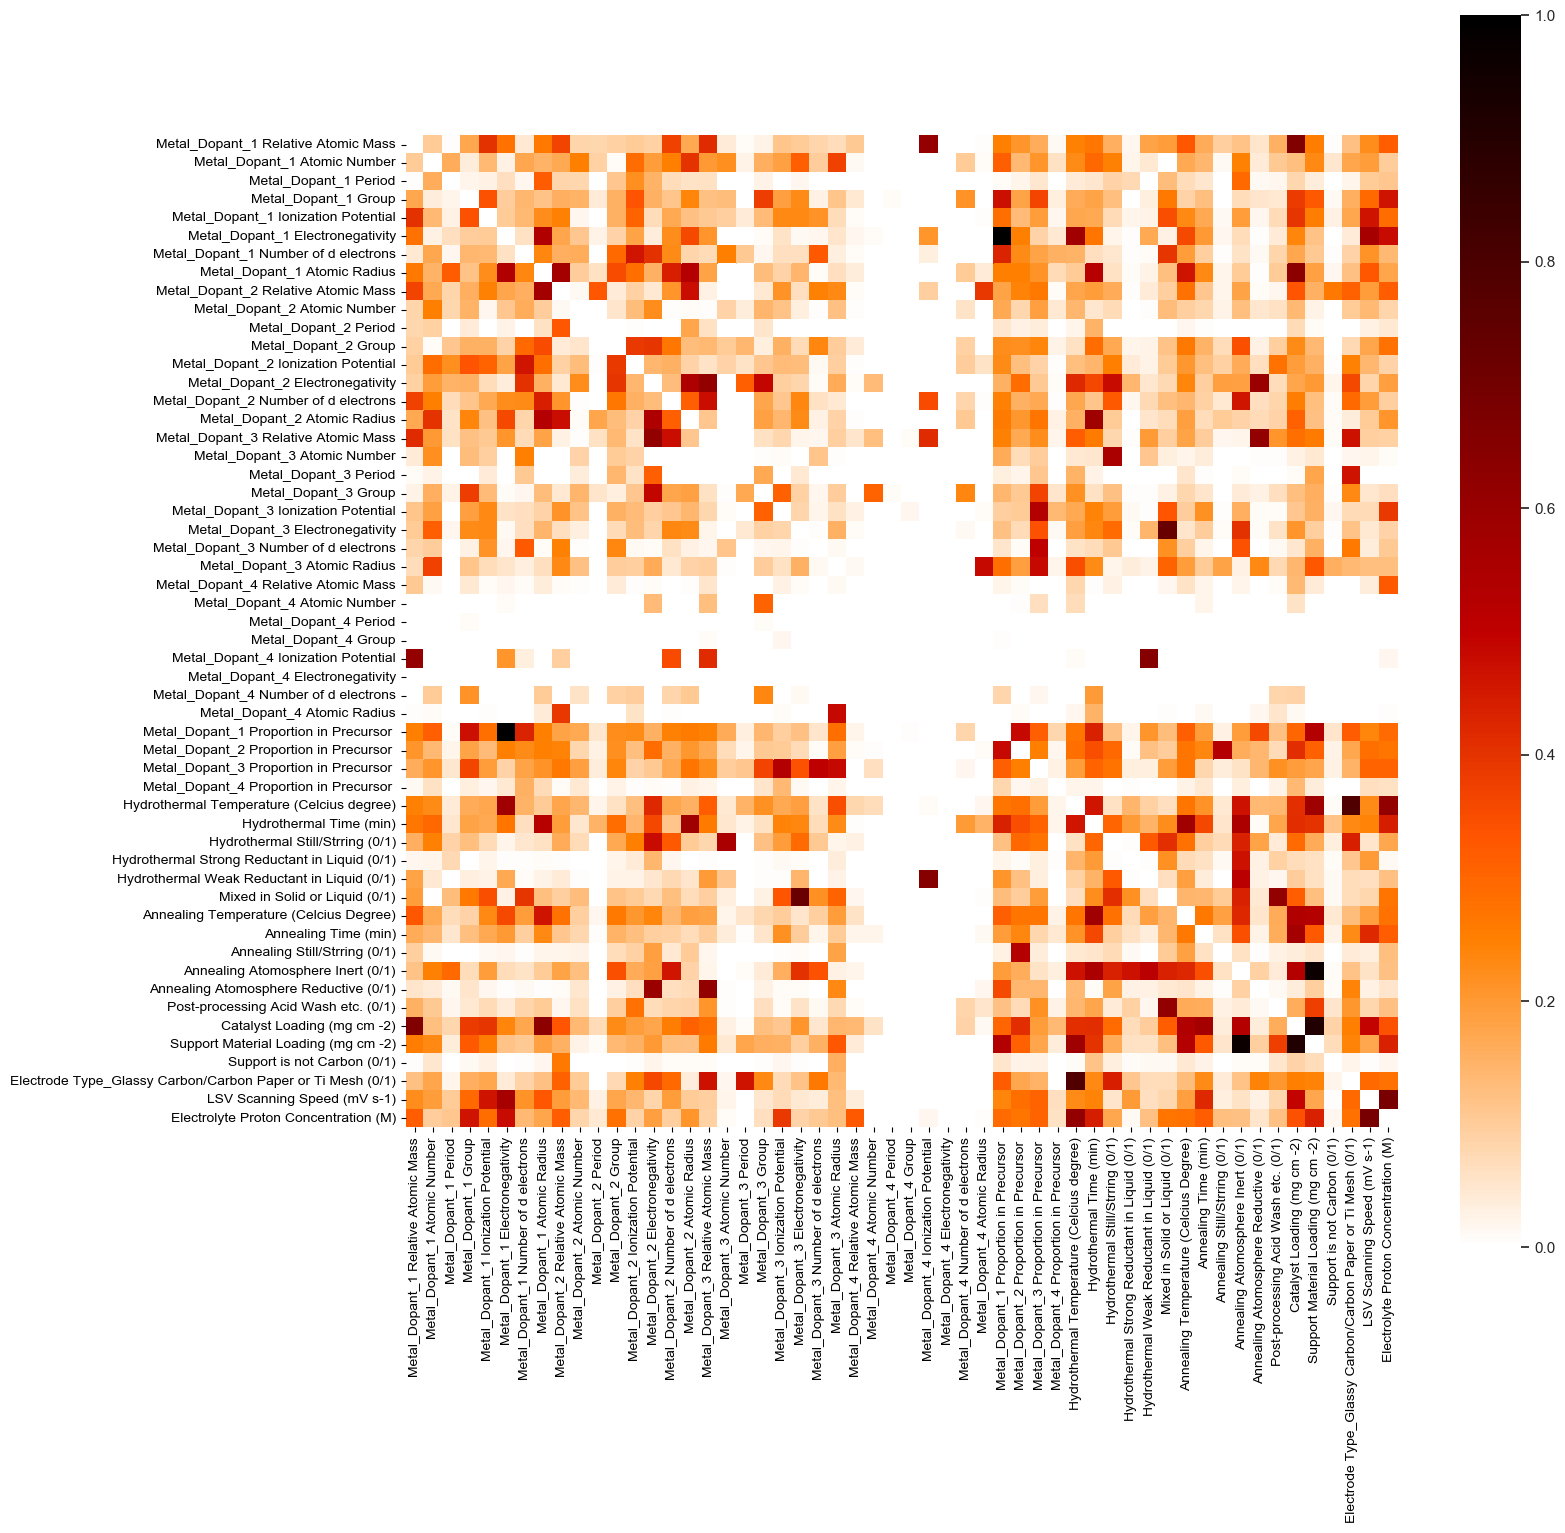

In [18]:
import seaborn as sns

f, ax= plt.subplots(figsize = (16, 16))
sns.set(font_scale=1)
ax=sns.heatmap(Weighted_Matrix,annot=False, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True, cmap="gist_heat_r")

In [19]:
Element_M=Weighted_Matrix.iloc[0:36,0:36]
Synthesis_M=Weighted_Matrix.iloc[36:55,36:55]

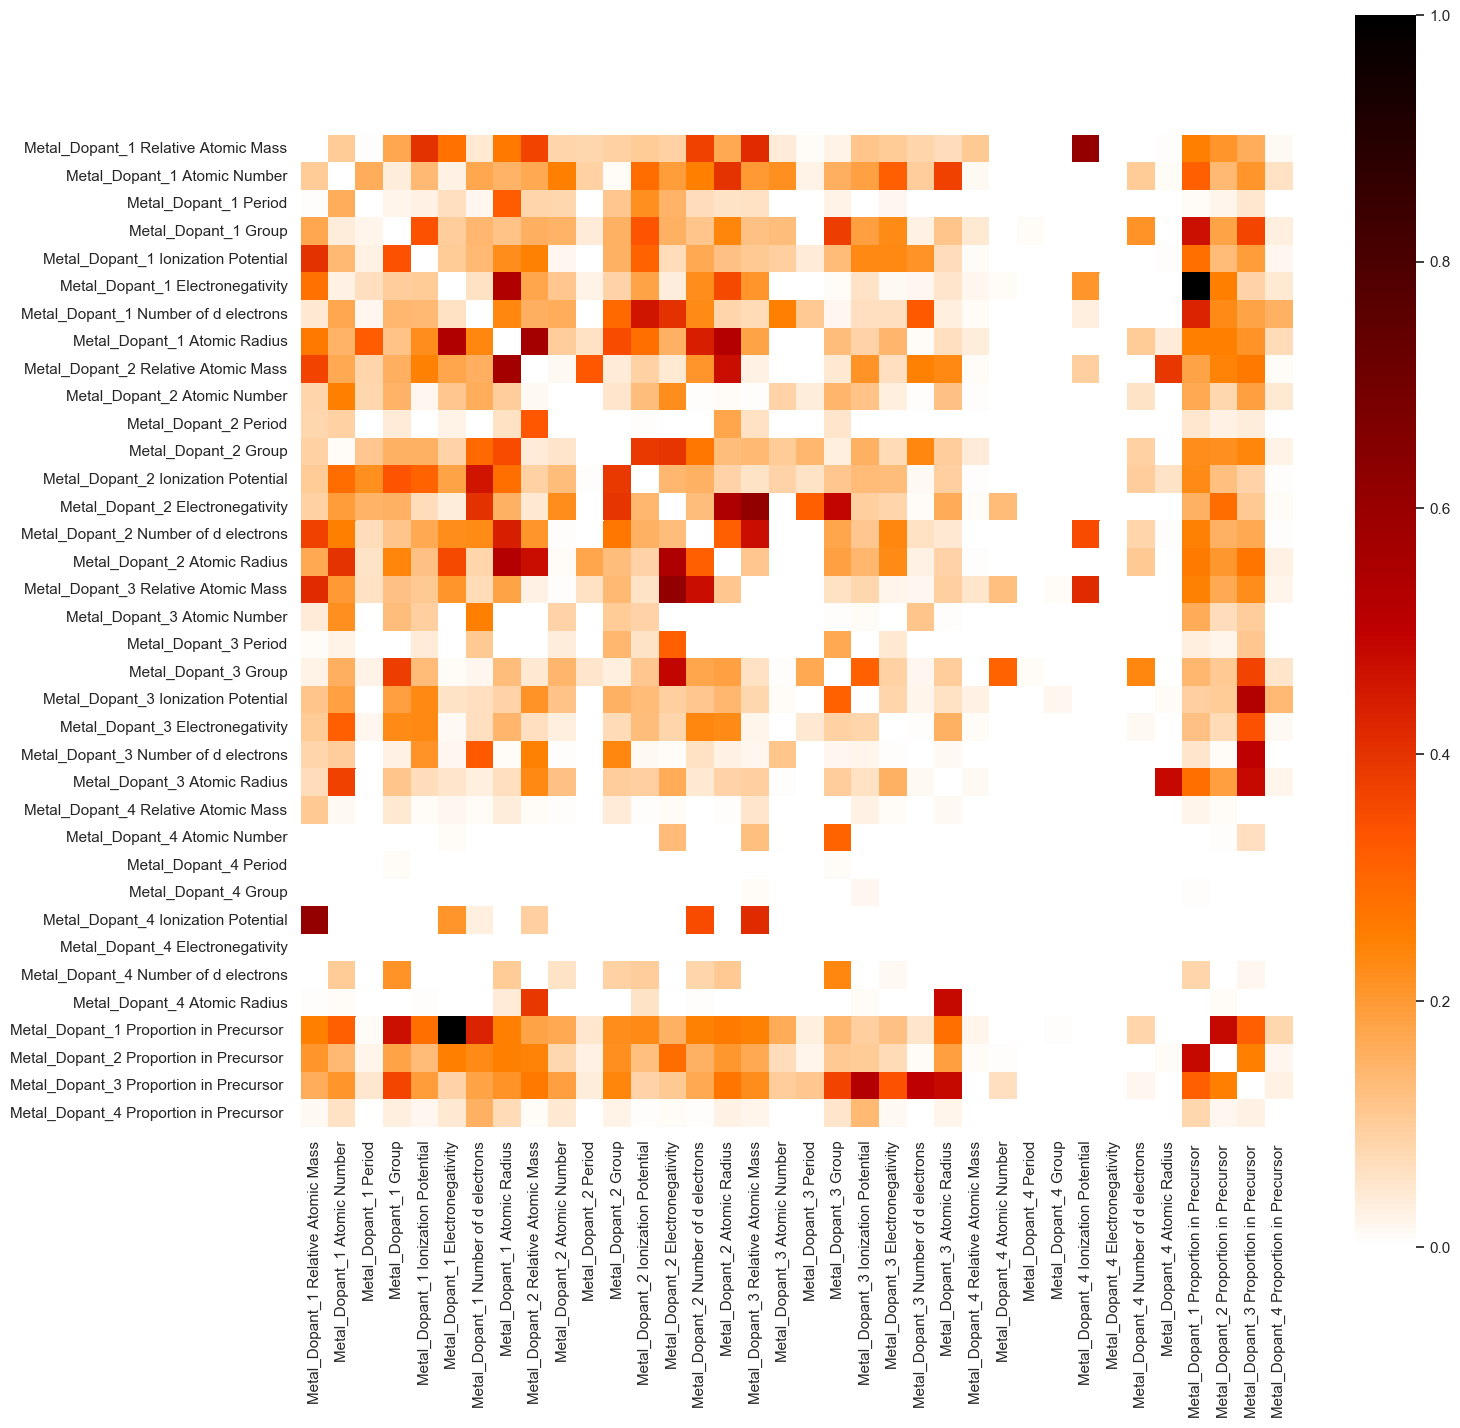

In [20]:
f1, ax1= plt.subplots(figsize = (16, 16))
# sns.set(font_scale=2)
ax1=sns.heatmap(Element_M,annot=False, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True, cmap="gist_heat_r")

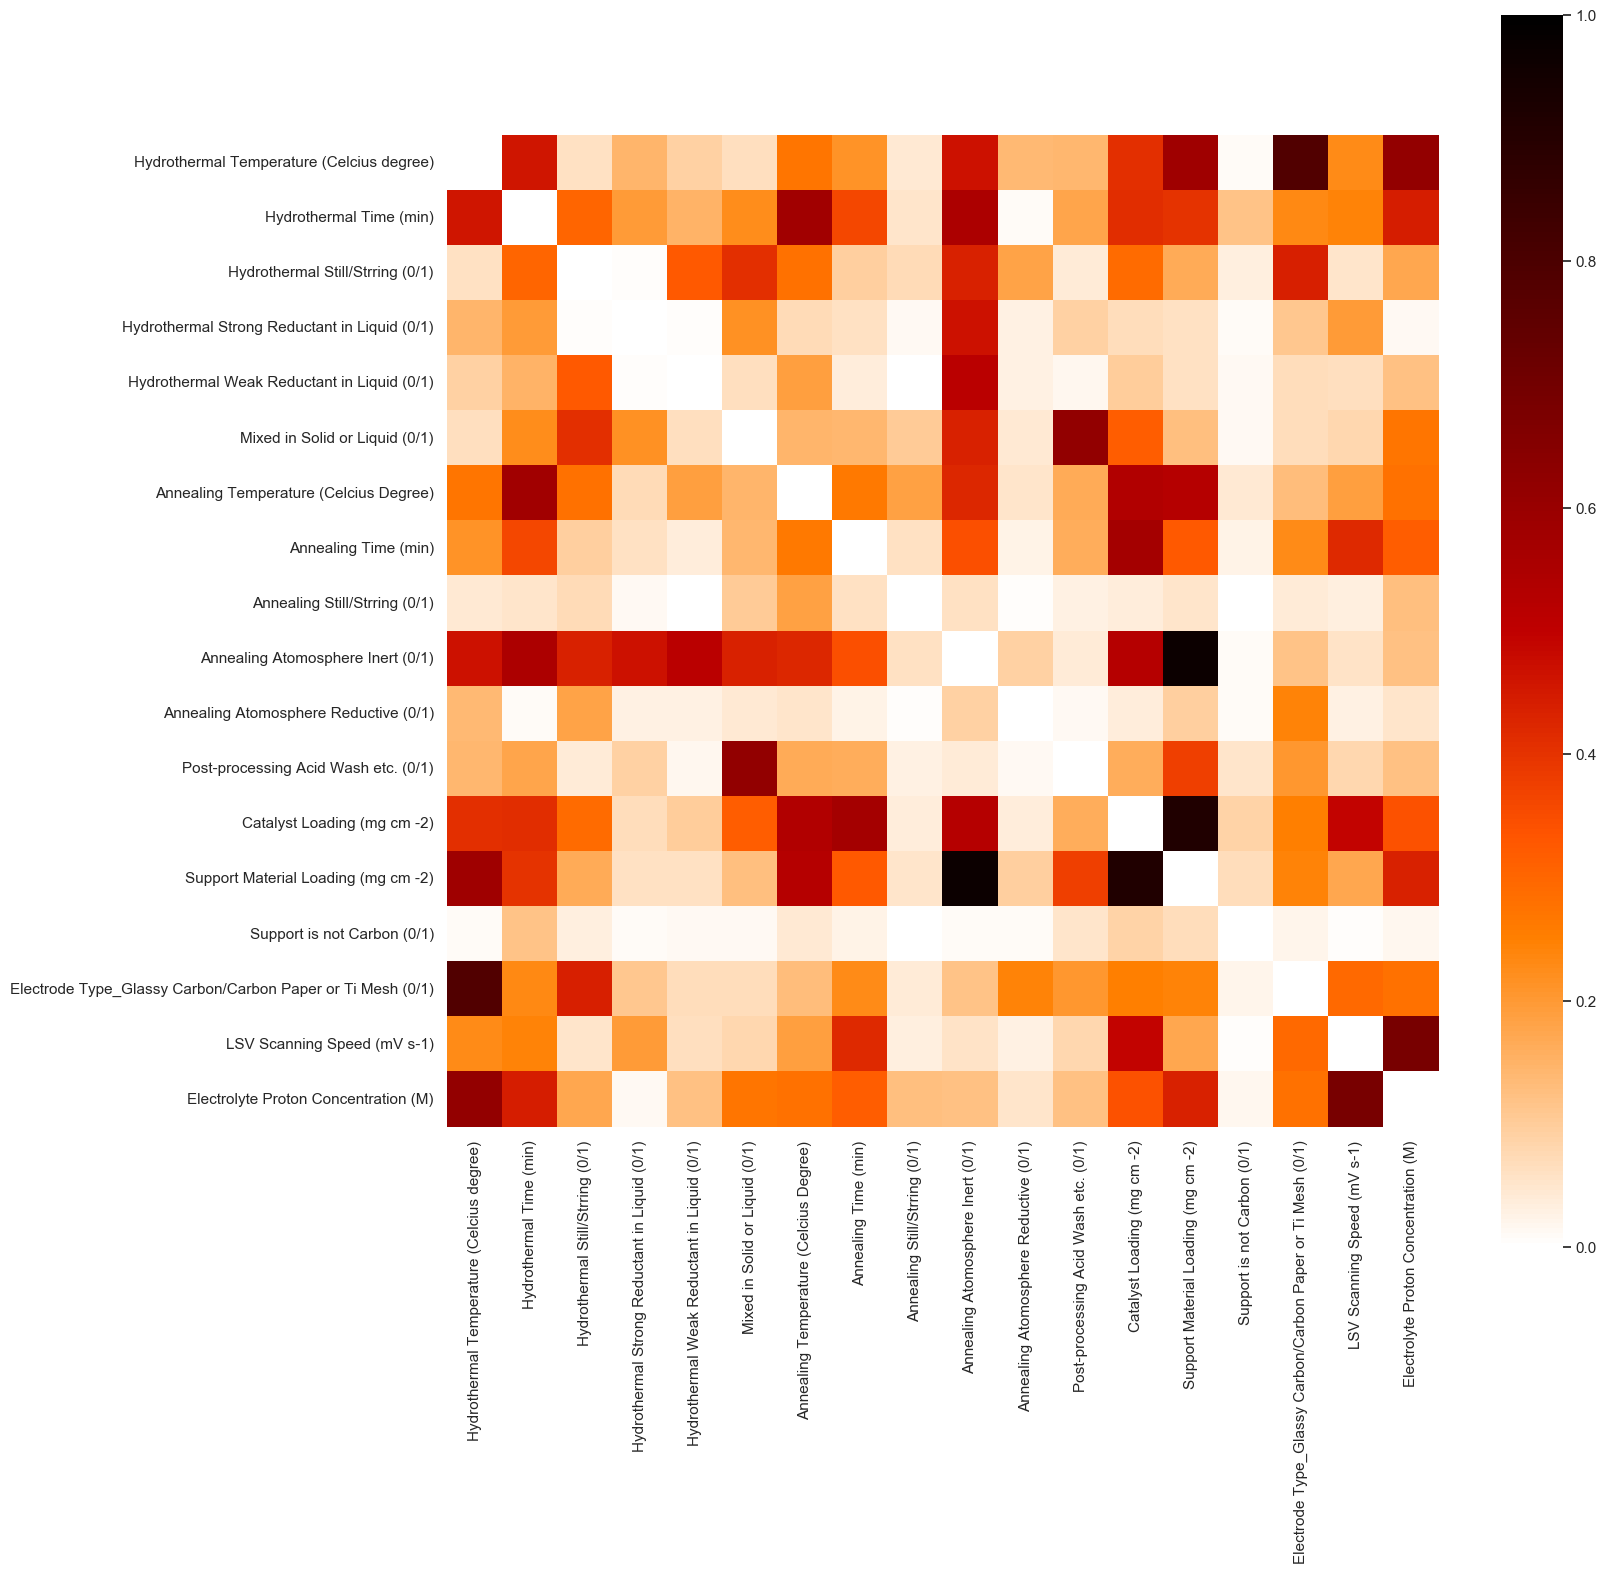

In [21]:
f2, ax2= plt.subplots(figsize = (16, 16))
# sns.set(font_scale=2)
ax2=sns.heatmap(Synthesis_M,annot=False, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True, cmap="gist_heat_r")